# Modify this variable to adapt to your storage in you're cloud

In [11]:
# project location in Google drive
project_location_drive = '/content/drive/MyDrive/Fac/Master/CV'
project_location_local = '/content/'

#
data_location_local = "/content/data/media/nas/01_Datasets/CT/LITS/"

In [1]:
import wandb

In [2]:
! wandb login

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tpoux (tumor-3D) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# copy all the folder so the data leave on the same host has the GPU used
! cp -rv /content/drive/MyDrive/Fac/Master/CV/* /content/

'/content/drive/MyDrive/Fac/Master/CV/checkpoints' -> '/content/checkpoints'
'/content/drive/MyDrive/Fac/Master/CV/checkpoints/run_continued_last.pth' -> '/content/checkpoints/run_continued_last.pth'
'/content/drive/MyDrive/Fac/Master/CV/checkpoints/run_continued_best.pth' -> '/content/checkpoints/run_continued_best.pth'
'/content/drive/MyDrive/Fac/Master/CV/checkpoints/checkpoint_last.pth' -> '/content/checkpoints/checkpoint_last.pth'
'/content/drive/MyDrive/Fac/Master/CV/checkpoints/checkpoint_best.pth' -> '/content/checkpoints/checkpoint_best.pth'
'/content/drive/MyDrive/Fac/Master/CV/data' -> '/content/data'
'/content/drive/MyDrive/Fac/Master/CV/data/Training_Batch2.zip' -> '/content/data/Training_Batch2.zip'
'/content/drive/MyDrive/Fac/Master/CV/data/Training_Batch1.zip' -> '/content/data/Training_Batch1.zip'
'/content/drive/MyDrive/Fac/Master/CV/dataset' -> '/content/dataset'
'/content/drive/MyDrive/Fac/Master/CV/dataset/LiTSSliceDataset.py' -> '/content/dataset/LiTSSliceDataset.

In [5]:
# unzip dataset in //
!unzip /content/data/Training_Batch1.zip -d /content/data/ & \
 unzip /content/data/Training_Batch2.zip -d /content/data/ & \
 wait

Archive:  /content/data/Training_Batch2.zip
Archive:  /content/data/Training_Batch1.zip
checkdir error:  cannot create /content/data/media
                 File exists
                 unable to process media/nas/01_Datasets/CT/LITS/Training Batch 2/segmentation-100.nii.
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-0.nii    inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 2/segmentation-101.nii  
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-1.nii  
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-10.nii  
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-11.nii  
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-12.nii  
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/Training Batch 2/segmentation-102.nii  
  inflating: /content/data/media/nas/01_Datasets/CT/LITS/

In [6]:
! rm -r  /content/data/Training_Batch1.zip
! rm -r  /content/data/Training_Batch2.zip

In [30]:
import torch
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from dataset.LiTSPatchDataset import *
from utility.dice_score import dice_loss_fg, dice_eval
from utility.log_image import log_images_wandb
from tqdm import tqdm
from torch import sigmoid
from torch.amp import autocast, GradScaler
from UNet.unet_model import UNet
import os, re

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Device: cuda
GPU: NVIDIA L4


In [12]:
def build_pairs(*batch_dirs):
    pairs = []
    for d in batch_dirs:
        files = os.listdir(d)

        seg_files = [f for f in files if "segmentation" in f]
        for seg in sorted(seg_files):
            m = re.search(r"segmentation-(\d+)", seg)
            if not m:
                continue
            idx = m.group(1)


            vol_candidates = [
                f"volume-{idx}.nii",
            ]
            vol = next((v for v in vol_candidates if v in files), None)
            if vol is None:
                raise FileNotFoundError(f"Volume manquant pour {seg} dans {d}")

            pairs.append((os.path.join(d, vol), os.path.join(d, seg)))
    return pairs


pairs = build_pairs(os.path.join(data_location_local ,"Training Batch 1/"), os.path.join(data_location_local ,"Training Batch 2/"))
print("Nb paires:", len(pairs))
print(pairs[0])


X_paths = [p[0] for p in pairs]
y_paths = [p[1] for p in pairs]

Nb paires: 130
('/content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/volume-0.nii', '/content/data/media/nas/01_Datasets/CT/LITS/Training Batch 1/segmentation-0.nii')


In [13]:
def show_grid(dataset, n=10, rows=2, cols=5, alpha=0.45):
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
    axes = np.ravel(axes)

    for i in range(n):
        x, y = dataset[i]


        x2d = x[0].detach().cpu().numpy()

        # y can be [H,W] or [1,H,W]
        y_np = y.detach().cpu().numpy()
        if y_np.ndim == 3:
            y2d = y_np[0]
        else:
            y2d = y_np

        ax = axes[i]
        ax.imshow(x2d, cmap="gray", interpolation="nearest")

        # overlay only on the tumor pixels
        tumor = (y2d > 0.5)
        ax.imshow(np.ma.masked_where(~tumor, tumor), cmap="Reds", alpha=alpha, interpolation="nearest")

        # contour
        ax.contour(tumor.astype(np.uint8), levels=[0.5], linewidths=1)

        ax.set_title(f"i={i} | tumor px={tumor.sum()}")
        ax.axis("off")

    # if the grid is bigger than n
    for j in range(n, rows*cols):
        axes[j].axis("off")

    plt.suptitle("maching tumor segmentation with the corresponding volume")
    plt.tight_layout()
    plt.show()


def show_preds(model, dataset, device, indices, threshold=0.5, alpha=0.45, verbose=True):
    model.eval()
    n = len(indices)
    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))
    if n == 1:
        axes = np.expand_dims(axes, 0)

    with torch.no_grad():
        for r, idx in enumerate(indices):
            x, y = dataset[idx]

            # x: [C,H,W] -> [1,C,H,W]
            xb = x.unsqueeze(0).to(device)

            logits = model(xb)
            prob = torch.sigmoid(logits)[0, 0].detach().cpu().numpy()
            pred = (prob > threshold)

            x2d = x[0].detach().cpu().numpy()

            y_np = y.detach().cpu().numpy()
            y2d = y_np[0] if y_np.ndim == 3 else y_np
            gt = (y2d > 0.5)

            # 1) image
            axes[r, 0].imshow(x2d, cmap="gray")
            axes[r, 0].set_title(f"Image (idx={idx})")
            axes[r, 0].axis("off")

            # 2) GT overlay
            axes[r, 1].imshow(x2d, cmap="gray")
            axes[r, 1].imshow(np.ma.masked_where(~gt, gt), cmap="Reds", alpha=alpha)
            axes[r, 1].set_title(f"GT (tumor px={gt.sum()})")
            axes[r, 1].axis("off")

            # 3) Pred overlay
            axes[r, 2].imshow(x2d, cmap="gray")
            axes[r, 2].imshow(np.ma.masked_where(~pred, pred), cmap="Reds", alpha=alpha)
            axes[r, 2].set_title(f"Pred (tumor px={pred.sum()})")
            axes[r, 2].axis("off")


    plt.tight_layout()
    if verbose :
        plt.show()

    return fig, axes

In [14]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [15]:
def split_patients(patient_ids, train=0.8, val=0.15, test=0.05, seed=42):
    assert abs(train + val + test - 1.0) < 1e-9
    ids = list(patient_ids)
    random.Random(seed).shuffle(ids)

    n = len(ids)
    n_train = int(train * n)
    n_val = int(val * n)

    train_ids = ids[:n_train]
    val_ids   = ids[n_train:n_train+n_val]
    test_ids  = ids[n_train+n_val:]
    return train_ids, val_ids, test_ids

def make_paths(batch_dirs, patient_ids):
    X, Y = [], []
    for pid in patient_ids:
        for d in batch_dirs:
            vol = os.path.join(d, f"volume-{pid}.nii")
            seg = os.path.join(d, f"segmentation-{pid}.nii")
            if os.path.exists(vol) and os.path.exists(seg):
                X.append(vol); Y.append(seg)
                break
    return X, Y

max = 0
for d in [os.path.join(data_location_local ,"Training Batch 1/"), os.path.join(data_location_local ,"Training Batch 2/")]:
        files = os.listdir(d)

        seg_files = [f for f in files if "volume" in f]
        for seg in sorted(seg_files):
            m = re.search(r"volume-(\d+)", seg)
            if not m:
                continue
            if int(m[1]) > max:
                 max = int(m[1])
            else:
                 continue

patient_ids = np.arange(max+1)

train_ids, val_ids, test_ids = split_patients(patient_ids)



X_train_paths, y_train_paths  = make_paths([os.path.join(data_location_local ,"Training Batch 1/"), os.path.join(data_location_local ,"Training Batch 2/")], train_ids)
X_val_paths, y_val_paths= make_paths([os.path.join(data_location_local ,"Training Batch 1/"), os.path.join(data_location_local ,"Training Batch 2/")], val_ids)
X_test_paths, y_test_paths= make_paths([os.path.join(data_location_local ,"Training Batch 1/"), os.path.join(data_location_local ,"Training Batch 2/")], test_ids)
train_dataset = LiTSPatchDataset(X_train_paths,y_train_paths)
val_dataset = LiTSPatchDataset(X_val_paths,y_val_paths)
test_dataset = LiTSPatchDataset(X_test_paths,y_test_paths)



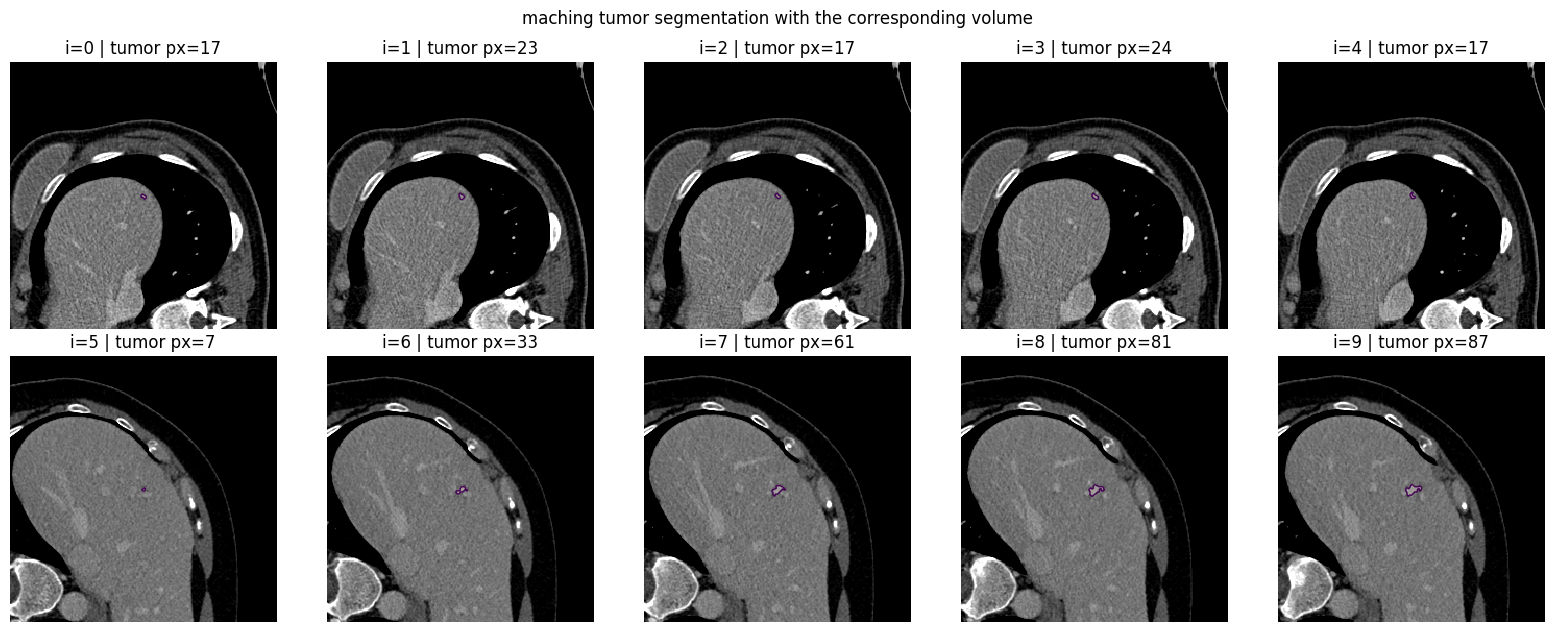

In [16]:
show_grid(val_dataset, n=10, rows=2, cols=5, alpha=0.45)

In [ ]:
def unet_train(
    model,
    train_dataset,
    val_dataset,
    device,
    epochs: int = 10,
    batch_size: int = 1,
    l_rate: float = 1e-4,
    save_checkpoints: bool = True,
    weight_decay: float = 1e-5,
    patience: int = 7,
    min_delta: float = 0.005,
    run_name: str = "run",
    early_stop: bool = True,
    verbose: bool = True
):

    hyperparameters = locals().copy() # get all parameters from the function call

    use_amp = (device.type == "cuda")
    scaler = GradScaler("cuda", enabled=use_amp)

    loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True)




    train_loader = DataLoader(
        train_dataset,
        batch_size=loader_args["batch_size"],
        num_workers=loader_args["num_workers"],
        pin_memory=loader_args["pin_memory"],
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=loader_args["batch_size"],
        num_workers=loader_args["num_workers"],
        pin_memory=loader_args["pin_memory"],
        shuffle=False,
        drop_last=False
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=l_rate,
        betas=(0.9, 0.999),
        weight_decay=weight_decay
    )

    pos_weight = torch.tensor([25.0], device=device)
    bce_loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


    max_scan = min(len(val_dataset), 2000)
    tumor_idx, empty_idx = None, None

    for i in range(max_scan):
        _, y_tmp = val_dataset[i]
        if isinstance(y_tmp, np.ndarray):
            y_tmp = torch.from_numpy(y_tmp)
        s = y_tmp.sum().item()
        if s > 0 and tumor_idx is None:
            tumor_idx = i
        if s == 0 and empty_idx is None:
            empty_idx = i
        if (tumor_idx is not None and len(tumor_idx) >= 3 and (empty_idx is not None and  len(empty_idx) >= 3 )):
            break

    if tumor_idx is None: tumor_idx = 0
    if empty_idx is None: empty_idx = 1 if len(val_dataset) > 1 else 0

    viz_subset = Subset(val_dataset, [tumor_idx, empty_idx])

    losses_train, losses_val, dices_val = [], [], []

    best_dice = -1.0
    epochs_no_improve = 0


    hyperparameters.update(loader_args.copy())


    with wandb.init(project="tumor-3D", config=hyperparameters, name=run_name):

      for epoch in range(epochs):
          model.train()
          cum_loss = 0.0
          nb_batches = 0

          for x_batch, y_batch in tqdm(train_loader, desc=f"Train epoch {epoch}", leave=False):
              x = x_batch.to(device)
              y = y_batch.to(device)

              if y.dim() == 3:
                  y = y.unsqueeze(1)
              y = y.float()

              optimizer.zero_grad(set_to_none=True)

              with autocast(enabled=use_amp, device_type="cuda" if torch.cuda.is_available() else "cpu"):
                  logits = model(x)
                  loss = dice_loss_fg(logits, y) + bce_loss(logits, y)

              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()

              cum_loss += float(loss.item())
              nb_batches += 1
              wandb.log({"loss_train": float(loss.item())})


          loss_epoch = cum_loss / nb_batches if nb_batches > 0 else float("nan")

          wandb.log({"epoch": epoch, "loss_train": loss_epoch})

          model.eval()
          cum_loss_val = 0.0
          nb_val_batches = 0
          dice_sum = 0.0
          n_sum = 0

          with torch.no_grad():
              for x_batch, y_batch in tqdm(val_loader, desc=f"Val epoch {epoch}", leave=False):
                  x = x_batch.to(device)
                  y = y_batch.to(device)

                  if y.dim() == 3:
                      y = y.unsqueeze(1)
                  y = y.float()

                  with autocast(enabled=use_amp, device_type="cuda" if torch.cuda.is_available() else "cpu"):
                      logits = model(x)
                      batch_loss_val = dice_loss_fg(logits, y) + bce_loss(logits, y)

                  dice_batch, n_valid = dice_eval(logits, y)
                  dice_sum += float(dice_batch) * int(n_valid)
                  n_sum += int(n_valid)

                  cum_loss_val += float(batch_loss_val.item())
                  nb_val_batches += 1

          dice_epoch = (dice_sum / n_sum) if n_sum > 0 else float("nan")
          loss_val_epoch = (cum_loss_val / nb_val_batches) if nb_val_batches > 0 else float("nan")

          losses_train.append(loss_epoch)
          losses_val.append(loss_val_epoch)
          dices_val.append(dice_epoch)

          wandb.log({"epoch": epoch, "loss_val": loss_val_epoch, "dice_val": dice_epoch})


          print("=="*10, f"epoch {epoch} metrics results", "=="*10)
          print(f"train loss: {loss_epoch:.6f}")
          print(f"val   loss: {loss_val_epoch:.6f}")
          print(f"val   dice: {dice_epoch}")

          if epoch % 2 == 0:
            log_images_wandb(model,
                            val_dataset,
                            device,
                            indices=[tumor_idx, empty_idx],
                            epoch=epoch,
                            threshold=0.5,
                            alpha=0.45)


          if save_checkpoints:
              ckpt = {
                  "epoch": epoch,
                  "model_state_dict": model.state_dict(),
                  "optimizer_state_dict": optimizer.state_dict(),
                  "best_dice": best_dice,
                  "loss_train": losses_train,
                  "loss_val": losses_val,
                  "dice_val": dices_val,
              }
              torch.save(ckpt, f"{run_name}_last.pth")

          if early_stop:

            if not np.isnan(dice_epoch) and dice_epoch > best_dice + min_delta:
              best_dice = dice_epoch
              epochs_no_improve = 0

              if save_checkpoints:
                ckpt["best_dice"] = best_dice
                torch.save(ckpt, f"{run_name}_best.pth")
            else:
              epochs_no_improve += 1
            if epochs_no_improve == 0 :
              print(
                  f"Best Dice: {best_dice:.4f} | "
                  f"Improving"
                )
            else :
              print(
                  f"Best Dice: {best_dice:.4f} | "
                  f"No improve: {epochs_no_improve}/{patience}"
                )

            if epochs_no_improve >= patience:
              print(f"Early stopping triggered at epoch {epoch}!")
              break

      artifact = wandb.Artifact('Unet', type='model')
      if os.path.exists(f"{run_name}_best.pth"):
        artifact.add_file(f"{run_name}_best.pth")
      else :
        artifact.add_file(f"{run_name}_last.pth")
      wandb.log_artifact(artifact)

      if verbose :

        plt.plot(losses_train, label="train")
        plt.plot(losses_val, label="val")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        plt.plot(dices_val, label="val dice")
        plt.title("Dice")
        plt.xlabel("Epochs")
        plt.ylabel("Dice")
        plt.legend()
        plt.show()



    return losses_train, losses_val, dices_val


In [19]:
import torch
import gc

def flush_memory():
    # 1. On force le Garbage Collector de Python
    gc.collect()
    # 2. On vide le cache CUDA
    torch.cuda.empty_cache()
    # 3. (Optionnel) Si tu es sur une architecture spécifique
    torch.cuda.ipc_collect()

# flush_memory()

In [20]:
unet = UNet(1, 1, bilinear = True).to(device)
losses_train, losses_val, dices_val = unet_train(unet, train_dataset=train_dataset, val_dataset=val_dataset, device = device, epochs=100, batch_size=64, min_delta=0.001, patience=10, run_name="run_new_lr", verbose=False, l_rate=1e-5, early_stop=False)
#

KeyboardInterrupt: 

In [21]:
max_epochs = 120
patience = 7
min_delta = 0.005

In [36]:
from utility.log_image import log_images_wandb

In [48]:
unet = UNet(1, 1, bilinear=True).to(device)



checkpoint = torch.load("./checkpoints/checkpoint_best.pth", map_location=device)

unet.load_state_dict(checkpoint["model_state_dict"])


losses_train, losses_val, dices_val = unet_train(
    model=unet,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    epochs=50,
    batch_size=32,
    l_rate=3e-4,
    patience=7,
    weight_decay=1e-4,
    min_delta=0.005,
    run_name="run_give_a_name"
)



==================== epoch 0 metrics results ====================
train loss: 1.058200
val   loss: 1.328625
val   dice: 0.5104567590404553
logging
(array([0, 1], dtype=uint8), array([65504,    32]))
(array([0, 1], dtype=uint8), array([65519,    17]))
(array([0, 1], dtype=uint8), array([65483,    53]))
(array([0, 1], dtype=uint8), array([65513,    23]))
Best Dice: 0.5105 | Improving


==================== epoch 1 metrics results ====================
train loss: 0.829180
val   loss: 1.327434
val   dice: 0.5141913521267116
logging
(array([0, 1], dtype=uint8), array([65533,     3]))
(array([0, 1], dtype=uint8), array([65519,    17]))
(array([0, 1], dtype=uint8), array([65529,     7]))
(array([0, 1], dtype=uint8), array([65513,    23]))
Best Dice: 0.5105 | No improve: 1/7


==================== epoch 2 metrics results ====================
train loss: 0.696786
val   loss: 1.327586
val   dice: 0.5146781568988691
logging
(array([0], dtype=uint8), array([65536]))
(array([0, 1], dtype=uint8), array([65519,    17]))
(array([0], dtype=uint8), array([65536]))
(array([0, 1], dtype=uint8), array([65513,    23]))
Best Dice: 0.5105 | No improve: 2/7


==================== epoch 3 metrics results ====================
train loss: 0.590118
val   loss: 1.320160
val   dice: 0.5152581279009564
logging
(array([0], dtype=uint8), array([65536]))
(array([0, 1], dtype=uint8), array([65519,    17]))
(array([0], dtype=uint8), array([65536]))
(array([0, 1], dtype=uint8), array([65513,    23]))
Best Dice: 0.5105 | No improve: 3/7


Traceback (most recent call last):
  File "/tmp/ipython-input-447792938.py", line 126, in unet_train
    x = x_batch.to(device)
        ^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


dice_val,▁▆▇█
epoch,▁▁▃▃▅▅▆▆█
loss_train,██▅▅▃▃▂▂▁▁
loss_val,█▇▇▁
dice_val,0.51526
epoch,4
loss_train,0.51595
loss_val,1.32016


KeyboardInterrupt: 